# 2022-BBS-DM EXAM - Big Data pipeline

Use this notebook to create a Big Data pipeline with PySpark according to the instructions below.

It is optional to conclude this part by loading the results on Tableau and creating some OLAP queries.

## Submission

Submit your Notebook (and possibly your Tableau file) through the form at [this link](https://forms.gle/btQmVMrcPtQnoRgv7). 

In form, make your that:
- Your BBS email account is used
- File names begin with surname_name (e.g., rossi_mario_pyspark.ipynb)

## Evaluation

The Notebook will be mainly graded on the accuracy of the result; code quality and efficiency (e.g., using 1 line of code instead of 5 to do the same thing) will be considered as well, though with a lower weight.

The submission of the Tableau file can provide extra points.

# Install Spark & initialize application

Run the following code to install Spark in your Colab environment.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"
import findspark
findspark.init()
findspark.find() # Should return '/content/spark-3.2.1-bin-hadoop2.7'

'/content/spark-3.2.1-bin-hadoop2.7'

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
sc = spark.sparkContext

sc

<SparkContext master=local appName=Colab>

# MovieLens

[MovieLens](https://grouplens.org/datasets/movielens/) is a dataset about movies and ratings. You are working with two files:

- ml-movies.csv: contains details about the movies
  - Each movie is identified by ```movieId```
  - Each movie is associated to one or more genres, which are separated by a pipeline (e.g., "Adventure|Children|Fantasy")
- ml-ratings-1m.csv: contains 1 million ratings (in a range from 1 to 5) given by users to movies
  - Each rating is identified by ```movieId``` and ```userId```
  - Each rating is associated to a timestamp (e.g., 1256677221)

Your goal is to create a single file representing the following cube.

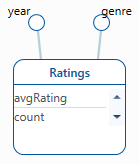

The procedure to create the cube is the following.

1. On the ml-movies.csv file:
  - Get rid of the title and userId columns
  - Each line represents a movie, and each movie has many genres. We want to "explode" the genres, in order to have the same movie repeated for each genre (i.e., the equivalent of the ```flatMap``` on RDDs. To do so:
    - Use the ```split(df['mycolumn'],"\\|")``` to split a column on the pipe character; it converts from one String to an array of Strings
    - Use the ```explode_outer()``` method on the result to produce one line per value
    - Replace null genres with the "Unknown" value
2. On the ml-ratings-1m.csv:
  - Convert the decimal character from comma to dot (as done during class)
  - Convert the timestamp to the "yyyy" format; to do so, use the ```from_unixtime(dfRatings['my_column'],"mydateformat")``` to convert from timestamp to the format of your choice
3. Join the two datasets on the ```movieId```
4. Aggregate the data by genre and year to calculate the average rating and count the records
5. Save the result to a file
6. (Optional) Open the file with Tableau and produce
  - the monthly trend of average ratings by genre;
  - a bar chart where, for each genre, the height is the number of ratings and the color is the average rating

In [ ]:
!wget https://raw.githubusercontent.com/w4bo/2022-bbs-dm/main/notebooks/datasets/ml-movies.csv
!wget https://raw.githubusercontent.com/w4bo/2022-bbs-dm/main/notebooks/datasets/ml-ratings-1m.csv

--2022-04-22 13:38:59--  https://raw.githubusercontent.com/w4bo/2022-bbs-dm/main/notebooks/datasets/ml-movies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2858181 (2.7M) [text/plain]
Saving to: ‘ml-movies.csv’

ml-movies.csv       100%[===================>]   2.73M  --.-KB/s    in 0.07s   

2022-04-22 13:39:00 (41.2 MB/s) - ‘ml-movies.csv’ saved [2858181/2858181]

--2022-04-22 13:39:00--  https://raw.githubusercontent.com/w4bo/2022-bbs-dm/main/notebooks/datasets/ml-ratings-1m.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [ ]:
from pyspark.sql.functions import *
import datetime

## Spark

1. On the ml-movies.csv file:
  - Get rid of the title and userId columns
  - Each line represents a movie, and each movie has many genres. We want to "explode" the genres, in order to have the same movie repeated for each genre (i.e., the equivalent of the ```flatMap``` on RDDs. To do so:
    - Use the ```split(df['mycolumn'],"\\|")``` to split a column on the pipe character; it converts from one String to an array of Strings
    - Use the ```explode_outer()``` method on the result to produce one line per value
    - Replace null genres with the "Unknown" value

In [ ]:
# TODO
df_movie = spark.read.option("delimiter", ",").option("header", "True").csv("ml-movies.csv")
df_movie.show()
from pyspark.sql.functions import concat, lit


+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|                null|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|                null|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|                null|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [ ]:
movies = df_movie.select('movieId','genres')
movies.show()

+-------+--------------------+
|movieId|              genres|
+-------+--------------------+
|      1|Adventure|Animati...|
|      2|Adventure|Childre...|
|      3|      Comedy|Romance|
|      4|Comedy|Drama|Romance|
|      5|              Comedy|
|      6|Action|Crime|Thri...|
|      7|                null|
|      8|  Adventure|Children|
|      9|                null|
|     10|Action|Adventure|...|
|     11|Comedy|Drama|Romance|
|     12|       Comedy|Horror|
|     13|Adventure|Animati...|
|     14|                null|
|     15|Action|Adventure|...|
|     16|         Crime|Drama|
|     17|       Drama|Romance|
|     18|              Comedy|
|     19|              Comedy|
|     20|Action|Comedy|Cri...|
+-------+--------------------+
only showing top 20 rows



In [ ]:
genres = df_movie.select('movieId', split(movies['genres'],"\\|").alias('genres'))
genres.show()

+-------+--------------------+
|movieId|              genres|
+-------+--------------------+
|      1|[Adventure, Anima...|
|      2|[Adventure, Child...|
|      3|   [Comedy, Romance]|
|      4|[Comedy, Drama, R...|
|      5|            [Comedy]|
|      6|[Action, Crime, T...|
|      7|                null|
|      8|[Adventure, Child...|
|      9|                null|
|     10|[Action, Adventur...|
|     11|[Comedy, Drama, R...|
|     12|    [Comedy, Horror]|
|     13|[Adventure, Anima...|
|     14|                null|
|     15|[Action, Adventur...|
|     16|      [Crime, Drama]|
|     17|    [Drama, Romance]|
|     18|            [Comedy]|
|     19|            [Comedy]|
|     20|[Action, Comedy, ...|
+-------+--------------------+
only showing top 20 rows



In [ ]:
genres_2 = genres.select('movieId', explode_outer('genres').alias('genres'))
genres_2.show()

+-------+---------+
|movieId|   genres|
+-------+---------+
|      1|Adventure|
|      1|Animation|
|      1| Children|
|      1|   Comedy|
|      1|  Fantasy|
|      2|Adventure|
|      2| Children|
|      2|  Fantasy|
|      3|   Comedy|
|      3|  Romance|
|      4|   Comedy|
|      4|    Drama|
|      4|  Romance|
|      5|   Comedy|
|      6|   Action|
|      6|    Crime|
|      6| Thriller|
|      7|     null|
|      8|Adventure|
|      8| Children|
+-------+---------+
only showing top 20 rows



In [ ]:
genres_2.na.fill(value="Unknown",subset=["genres"]).show()

+-------+---------+
|movieId|   genres|
+-------+---------+
|      1|Adventure|
|      1|Animation|
|      1| Children|
|      1|   Comedy|
|      1|  Fantasy|
|      2|Adventure|
|      2| Children|
|      2|  Fantasy|
|      3|   Comedy|
|      3|  Romance|
|      4|   Comedy|
|      4|    Drama|
|      4|  Romance|
|      5|   Comedy|
|      6|   Action|
|      6|    Crime|
|      6| Thriller|
|      7|  Unknown|
|      8|Adventure|
|      8| Children|
+-------+---------+
only showing top 20 rows



2. On the ml-ratings-1m.csv:
  - Convert the decimal character from comma to dot (as done during class)
  - Convert the timestamp to the "yyyy" format; to do so, use the ```from_unixtime(dfRatings['my_column'],"mydateformat")``` to convert from timestamp to the format of your choice

In [ ]:
# TODO
df_ratings = spark.read.option("delimiter", ";").option("header", "true").csv("ml-ratings-1m.csv")
df_ratings.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    307|   3,5|1256677221|
|     1|    481|   3,5|1256677456|
|     1|   1091|   1,5|1256677471|
|     1|   1257|   4,5|1256677460|
|     1|   1449|   4,5|1256677264|
|     1|   1590|   2,5|1256677236|
|     1|   1591|   1,5|1256677475|
|     1|   2134|   4,5|1256677464|
|     1|   2478|   4,0|1256677239|
|     1|   2840|   3,0|1256677500|
|     1|   2986|   2,5|1256677496|
|     1|   3020|   4,0|1256677260|
|     1|   3424|   4,5|1256677444|
|     1|   3698|   3,5|1256677243|
|     1|   3826|   2,0|1256677210|
|     1|   3893|   3,5|1256677486|
|     2|    170|   3,5|1192913581|
|     2|    849|   3,5|1192913537|
|     2|   1186|   3,5|1192913611|
|     2|   1235|   3,0|1192913585|
+------+-------+------+----------+
only showing top 20 rows



In [ ]:
df_ratings = df_ratings.withColumn('rating', regexp_replace('rating', ',', '\\.'))
df_ratings = df_ratings.withColumn('rating', df_ratings['rating'].cast("float"))
df_ratings = df_ratings.withColumn('timestamp', from_unixtime(df_ratings['timestamp'],"yyyy"))
df_ratings.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|    307|   3.5|     2009|
|     1|    481|   3.5|     2009|
|     1|   1091|   1.5|     2009|
|     1|   1257|   4.5|     2009|
|     1|   1449|   4.5|     2009|
|     1|   1590|   2.5|     2009|
|     1|   1591|   1.5|     2009|
|     1|   2134|   4.5|     2009|
|     1|   2478|   4.0|     2009|
|     1|   2840|   3.0|     2009|
|     1|   2986|   2.5|     2009|
|     1|   3020|   4.0|     2009|
|     1|   3424|   4.5|     2009|
|     1|   3698|   3.5|     2009|
|     1|   3826|   2.0|     2009|
|     1|   3893|   3.5|     2009|
|     2|    170|   3.5|     2007|
|     2|    849|   3.5|     2007|
|     2|   1186|   3.5|     2007|
|     2|   1235|   3.0|     2007|
+------+-------+------+---------+
only showing top 20 rows



3. Join the two datasets on the ```movieId```

In [ ]:
# TODO
df_movie_rating = df=movies.join(df_ratings,["movieId"])
df_movie_rating.show()

+-------+--------------------+------+------+---------+
|movieId|              genres|userId|rating|timestamp|
+-------+--------------------+------+------+---------+
|    307|               Drama|     1|   3.5|     2009|
|    481|      Drama|Thriller|     1|   3.5|     2009|
|   1091|              Comedy|     1|   1.5|     2009|
|   1257|      Comedy|Romance|     1|   4.5|     2009|
|   1449|              Comedy|     1|   4.5|     2009|
|   1590|Horror|Sci-Fi|Thr...|     1|   2.5|     2009|
|   1591|Action|Adventure|...|     1|   1.5|     2009|
|   2134|Comedy|Fantasy|Sc...|     1|   4.5|     2009|
|   2478|      Comedy|Western|     1|   4.0|     2009|
|   2840|      Drama|Thriller|     1|   3.0|     2009|
|   2986|Action|Crime|Sci-...|     1|   2.5|     2009|
|   3020|        Action|Drama|     1|   4.0|     2009|
|   3424|               Drama|     1|   4.5|     2009|
|   3698|       Action|Sci-Fi|     1|   3.5|     2009|
|   3826|Horror|Sci-Fi|Thr...|     1|   2.0|     2009|
|   3893|C

4. Aggregate the data by genre and year to calculate the average rating and count the records

In [ ]:
# TODO
df_movie_rating1 = df_movie_rating.groupBy("genres", "timestamp").agg({'rating': 'avg'})
df_movie_rating1.count()
df_movie_rating1.show()

+--------------------+---------+------------------+
|              genres|timestamp|       avg(rating)|
+--------------------+---------+------------------+
|Adventure|Animati...|     2000|               3.9|
|Crime|Drama|Sci-F...|     2013|3.8958333333333335|
|Action|Adventure|...|     2013|3.5609756097560976|
| Crime|Drama|Romance|     1996|3.5454545454545454|
|Action|Crime|Dram...|     1996| 2.472972972972973|
|Children|Comedy|R...|     2009|3.0555555555555554|
|Adventure|Animati...|     2009| 3.660427807486631|
|Adventure|Comedy|...|     2008|3.3714285714285714|
|           Drama|War|     2016| 3.945774647887324|
|Action|Sci-Fi|Thr...|     2004|3.5420258620689653|
|Animation|Childre...|     2009|              3.75|
|Action|Adventure|...|     2004|3.6485148514851486|
|Action|Adventure|...|     2018| 3.392857142857143|
|Crime|Drama|Film-...|     1999| 4.191489361702128|
|Fantasy|Horror|My...|     2010| 3.608695652173913|
|              Sci-Fi|     2010| 3.269230769230769|
|     Animat

5. Save the result to a file

In [ ]:
# TODO

df_movie_rating1.write.mode('overwrite').option('header','true').csv("df_movie_rating1")


## (Optional) Tableau

Open the file with Tableau and produce
  - the monthly trend of average ratings by genre;
  - a bar chart where, for each genre, the height is the number of ratings and the color is the average rating